# Lab: Trees and Model Stability

Trees are notorious for being **unstable**: Small changes in the data can lead to noticeable or large changes in the tree. We're going to explore this phenomenon, and a common rebuttal.

In the folder for this lab, there are three datasets that we used in class: Divorce, heart failure, and the AirBnB price dataset.

1. Pick one of the datasets and appropriately clean it.
2. Perform a train-test split for a specific seed (save the seed for reproducibility). Fit a classification/regression tree and a linear model on the training data and evaluate their performance on the test data. Set aside the predictions these models make.
3. Repeat step 2 for three to five different seeds (save the seeds for reproducibility). How different are the trees that you get? Your linear model coefficients?. Set aside the predictions these models make.

Typically, you would see the trees changing what appears to be a non-trivial amount, while the linear model coefficients don't vary nearly as much. Often, the changes appear substantial. 

But are they?

4. Instead of focusing on the tree or model coefficients, do three things:
    1. Make scatterplots of the predicted values on the test set from question 2 against the predicted values for the alternative models from part 3, separately for your trees and linear models. Do they appear reasonably similar?
    2. Compute the correlation between your model in part 2 and your alternative models in part 3, separately for your trees and linear models. Are they highly correlated or not?
    3. Run a simple linear regression of the predicted values on the test set from the alternative models on the predicted values from question 2, separately for your trees and linear models. Is the intercept close to zero? Is the slope close to 1? Is the $R^2$ close to 1?

5. Do linear models appear to have similar coefficients and predictions across train/test splits? Do trees?
6. True or false, and explain: "Even if the models end up having a substantially different appearance, the predictions they generate are often very similar."

## 1.

In [2]:
import pandas as pd
path = "data/airbnb_hw.csv"
df = pd.read_csv(path)
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [3]:
df_clean = df.copy()
df_clean["Price"] = pd.to_numeric(df_clean["Price"], errors="coerce") # converting Price to numeric
df_clean = df_clean.dropna(subset=["Price"])
df_clean = df_clean.drop(columns=["Host Id", "Host Since", "Name"]) # dropping irrelevant columns

numeric_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
numeric_cols.remove("Price")  # keeping as target

cat_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

for col in cat_cols:
    df_clean[col] = df_clean[col].fillna("Unknown")

# encoding categorical variables
df_model = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

X = df_model.drop(columns=["Price"])
y = df_model["Price"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (30297, 31)
Target shape: (30297,)


## 2.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

seed = 0  # example seed to save for reproducibility

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

tree = DecisionTreeRegressor(random_state=seed)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)

r2_tree = r2_score(y_test, y_pred_tree)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

r2_lin = r2_score(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

# evaluating just these results
predictions = {
    (seed, "tree"): y_pred_tree,
    (seed, "linear"): y_pred_lin
}
print(f"Decision Tree - R2: {r2_tree:.4f}, RMSE: {rmse_tree:.4f}")
print(f"Linear Regression - R2: {r2_lin:.4f}, RMSE: {rmse_lin:.4f}")


C:\Users\jonha\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.sparse import csr_matrix, issparse


Decision Tree - R2: 0.1908, RMSE: 99.6866
Linear Regression - R2: 0.4139, RMSE: 84.8382


The linear model outperforms the basic decision tree in this scenario.

## 3.

In [5]:
seeds = [0, 7, 42, 99, 2025]

results = []
lin_coefs = {}
tree_stats = {}
predictions = {}

for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=seed
    )
    
    tree = DecisionTreeRegressor(random_state=seed)
    tree.fit(X_train, y_train)
    y_pred_tree = tree.predict(X_test)
    
    lin = LinearRegression()
    lin.fit(X_train, y_train)
    y_pred_lin = lin.predict(X_test)
    
    # metrics
    r2_tree = r2_score(y_test, y_pred_tree)
    rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))

    r2_lin = r2_score(y_test, y_pred_lin)
    rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
    
    results.append({
        "seed": seed,
        "r2_tree": r2_tree,
        "rmse_tree": rmse_tree,
        "r2_lin": r2_lin,
        "rmse_lin": rmse_lin,
        "tree_depth": tree.get_depth(),
        "tree_n_leaves": tree.get_n_leaves()
    })
    
    # saving coefficients and tree stats
    lin_coefs[seed] = pd.Series(lin.coef_, index=X.columns)
    tree_stats[seed] = {
        "depth": tree.get_depth(),
        "n_leaves": tree.get_n_leaves()
    }
    
    # saving predictions
    predictions[(seed, "tree")] = y_pred_tree
    predictions[(seed, "linear")] = y_pred_lin

results_df = pd.DataFrame(results)
print(results_df)


   seed   r2_tree  rmse_tree    r2_lin   rmse_lin  tree_depth  tree_n_leaves
0     0  0.190795  99.686602  0.413905  84.838221          32          12760
1     7  0.257715  95.837186  0.423010  84.495322          34          12791
2    42  0.261799  95.808029  0.413469  85.400421          34          12851
3    99  0.270335  91.936744  0.442972  80.327791          34          12771
4  2025  0.273398  94.581942  0.420747  84.448924          34          12773


The trees are a bit different since the depth ranges from 32 to 34 but the number of leaves is always very large (~12.7k – 12.9k).

That tells us that all trees grow very deep and are highly branched on the training split and these different seeds give us slightly different splits (depth and leaves vary a bit), but all trees are similarly complex and overfit ish.

So yes, the exact splits and leaf structure are slightly different, but overall complexity and performance are fairly similar across seeds.

In [6]:
coef_df = pd.DataFrame(lin_coefs)  # rows = features cols = seeds
coef_summary = pd.DataFrame({
    "coef_mean": coef_df.mean(axis=1),
    "coef_std": coef_df.std(axis=1),
    "min_coef": coef_df.min(axis=1),
    "max_coef": coef_df.max(axis=1) 
}).sort_values("coef_std", ascending=False)

coef_summary.head(10)


,coef_mean,coef_std,min_coef,max_coef
Property Type_Lighthouse,-28.359888,63.414637,-1.417994e+02,4.263256e-14
Property Type_Treehouse,28.162542,51.492777,-6.086891e+01,7.307385e+01
Property Type_Hut,-39.172678,35.763171,-6.573880e+01,0.000000e+00
Property Type_Unknown,-50.155093,34.952731,-8.377487e+01,-2.220446e-16
Property Type_Other,83.126313,25.627865,4.748694e+01,1.112716e+02
Property Type_Chalet,42.297927,23.662668,-1.598721e-14,5.424577e+01
Property Type_Cabin,9.809227,22.385949,-1.246480e+01,4.556186e+01
Property Type_Bungalow,-21.905087,21.678511,-5.930112e+01,-4.471639e+00
Property Type_Castle,18.541945,16.928882,-6.039613e-14,3.131005e+01
Property Type_Camper/RV,-91.831080,14.321059,-1.172744e+02,-8.351611e+01


As for the linear model coefficients, some categories (like Property Type_Lighthouse, Property Type_Treehouse, Property Type_Hut) were rare and show large variation in coefficients across seeds (high coef_std), because they have very few listings and small changes in the train/test split can change their estimated effect a lot.

More common predictors (like Beds, Review Scores Rating, etc) generally have much smaller standard deviations in their coefficients across seeds so it means that those effects are more stable.

## Q4

### Q4.1

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
initial_tree = predictions.pop((0, "tree"))
initial_linear = predictions.pop((0, "linear")) 

#### Linear Model Scatterplots

To answer the question - for the linear models, they do seem to be reasonably similar. There are a few predictions that are outliers but not too many!

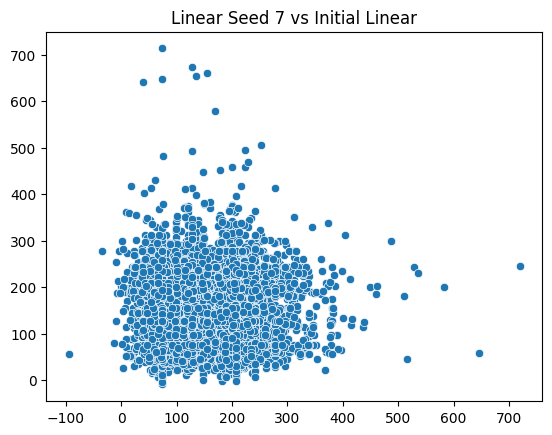

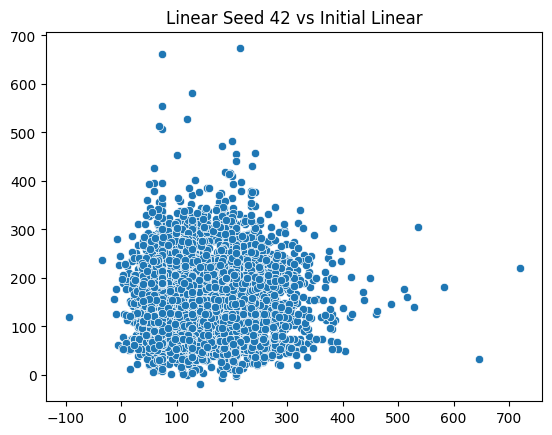

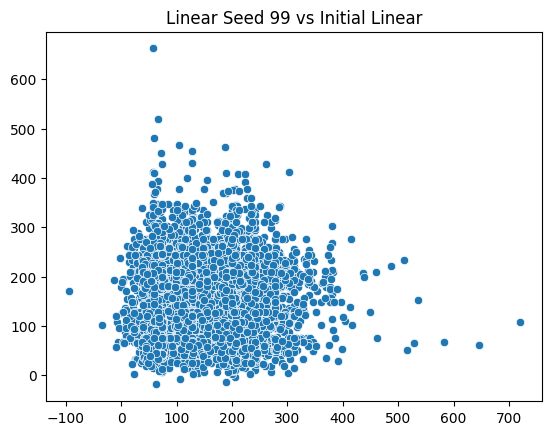

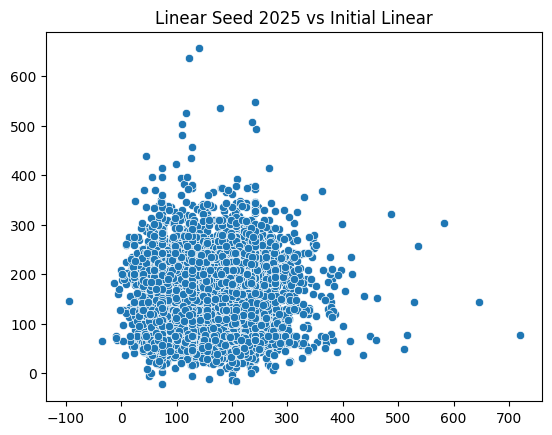

In [9]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        sns.scatterplot(x=initial_linear, y=preds)
        plt.title(f"Linear Seed {seed} vs Initial Linear")
        plt.show()

#### Tree Model Scatterplots

For the tree models, we can see that they're still reasonably similar but there are a few noticeable differences in terms of symmetry (indicating, difference in prediction values).

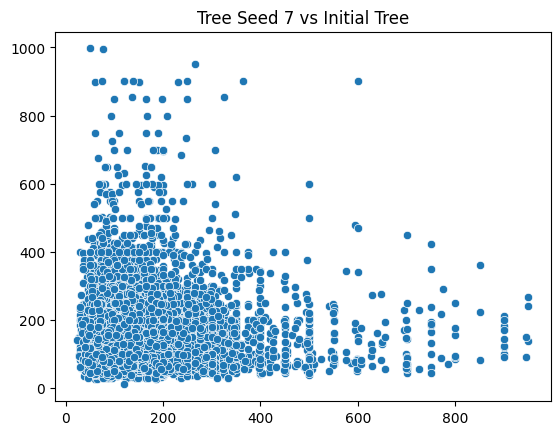

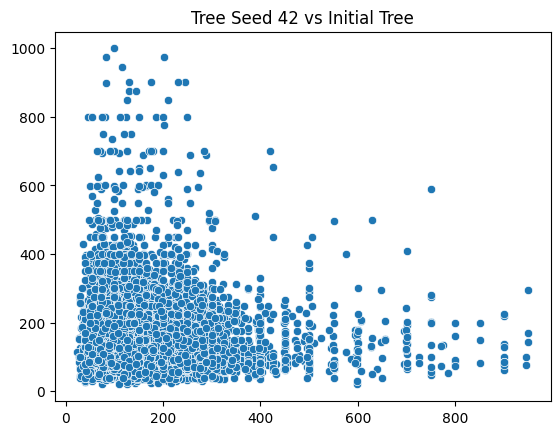

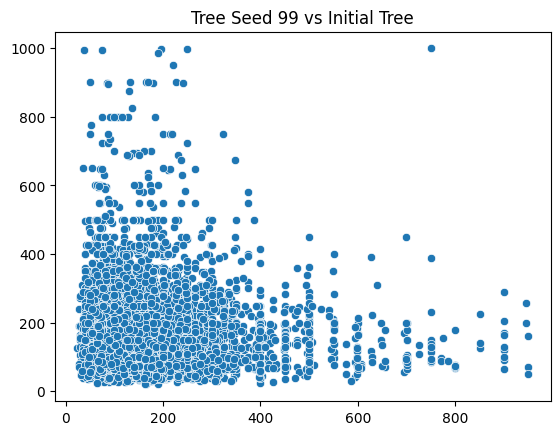

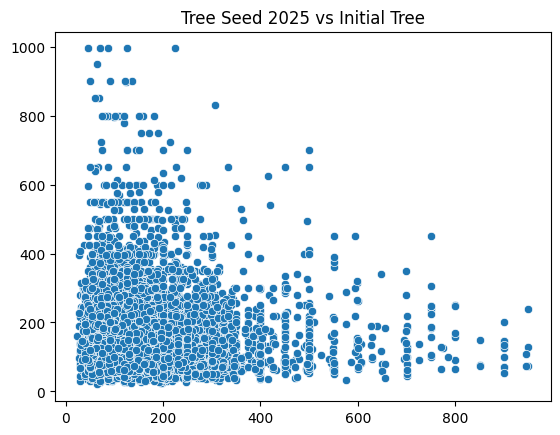

In [10]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        sns.scatterplot(x=initial_tree, y=preds)
        plt.title(f"Tree Seed {seed} vs Initial Tree")
        plt.show()

### Q4.2

For both the linear models and the tree models, the initial versions are not highly correlated with their alternative seeds. This is unsurprising as if they were close (not correlated, but close) then they'd be symmetrical, which may not necessarily be linear, hence the low correlation.

In [11]:
linear_correlations = {}
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        linear_correlations[seed] = np.corrcoef(initial_linear, preds)[0, 1]

linear_correlations

{7: np.float64(-0.010508070293406477),
 42: np.float64(0.0003645532067765593),
 99: np.float64(-0.0037215672020534797),
 2025: np.float64(0.015258316807674237)}

In [12]:
tree_correlations = {}
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        tree_correlations[seed] = np.corrcoef(initial_tree, preds)[0, 1]

tree_correlations

{7: np.float64(0.008015354211557999),
 42: np.float64(-0.01437179270962208),
 99: np.float64(0.0008033378901324859),
 2025: np.float64(0.0036955741051895447)}

### Q4.3

So I'll answer it for both because the answer is the same. The intercept is not close to zero for any of them lol, they're all around 155. The slope is close 0, not 1, and R^2 is also not close to 1 (closer to 0). This kind of makes sense?

In [13]:
from sklearn.linear_model import LinearRegression

Seed 7:
Intercept: 155.2036540143502
Coefficient: [-0.01045276]
R^2: 0.00011041954129109577


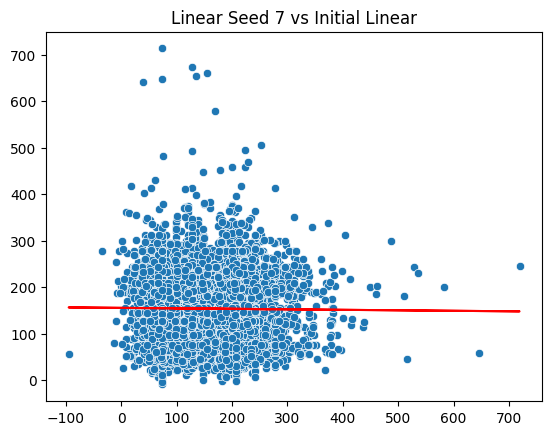

Seed 42:
Intercept: 153.2438870124573
Coefficient: [0.00036166]
R^2: 1.3289904066127178e-07


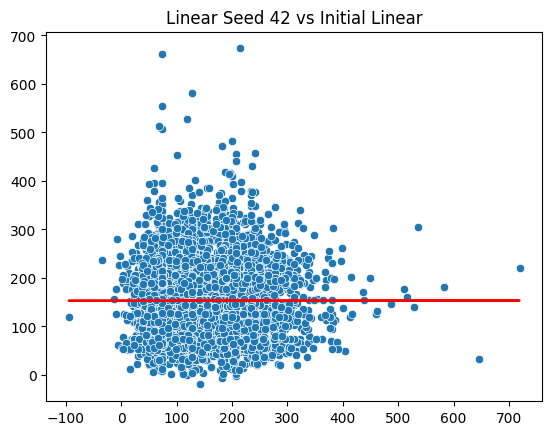

Seed 99:
Intercept: 153.82706295456592
Coefficient: [-0.00364032]
R^2: 1.3850062439590971e-05


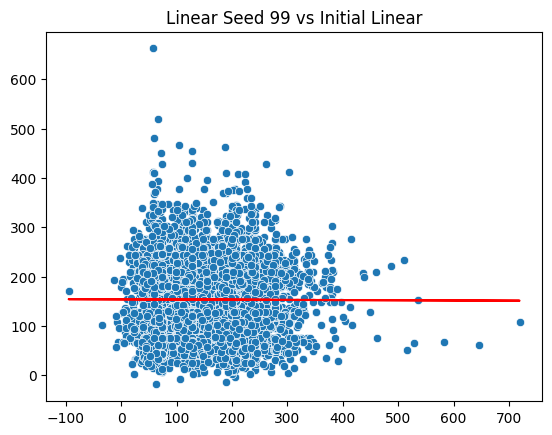

Seed 2025:
Intercept: 150.93581478509424
Coefficient: [0.01502721]
R^2: 0.00023281623180326783


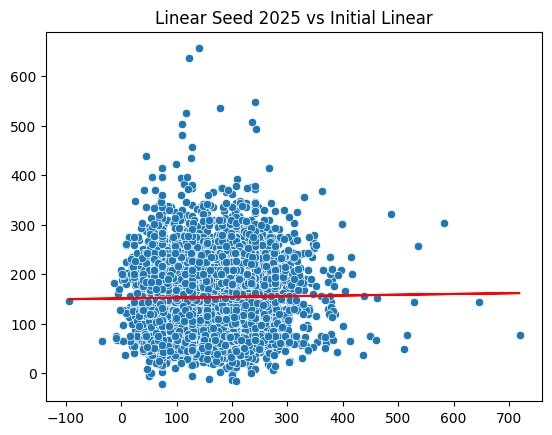

In [14]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "linear":
        sns.scatterplot(x=initial_linear, y=preds)
        reshaped_initial = initial_linear.reshape(-1, 1)
        model = LinearRegression().fit(reshaped_initial, preds)
        print(f"Seed {seed}:")
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficient: {model.coef_}")
        print(f"R^2: {model.score(reshaped_initial, preds)}")
        plt.title(f"Linear Seed {seed} vs Initial Linear")
        plt.plot(initial_linear, model.predict(reshaped_initial), color='red')
        plt.show()

Seed 7:
Intercept: 152.58324212498454
Coefficient: [0.00766465]
R^2: 6.424590313680589e-05


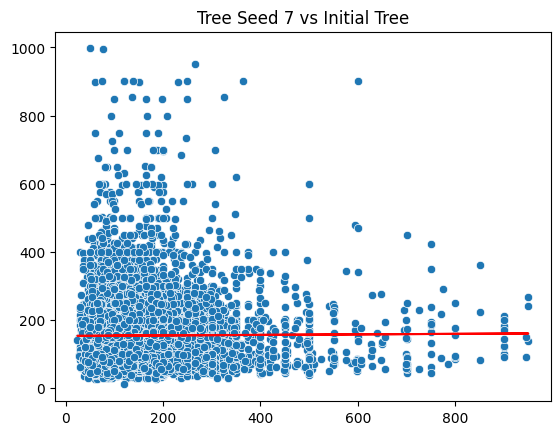

Seed 42:
Intercept: 155.2822160761421
Coefficient: [-0.0135958]
R^2: 0.00020654842568834653


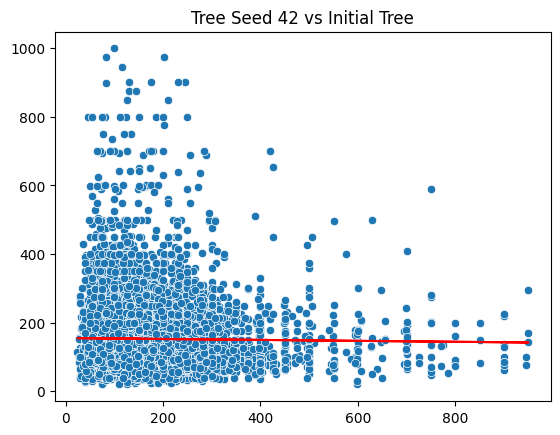

Seed 99:
Intercept: 154.2887289818643
Coefficient: [0.00077844]
R^2: 6.453517656934693e-07


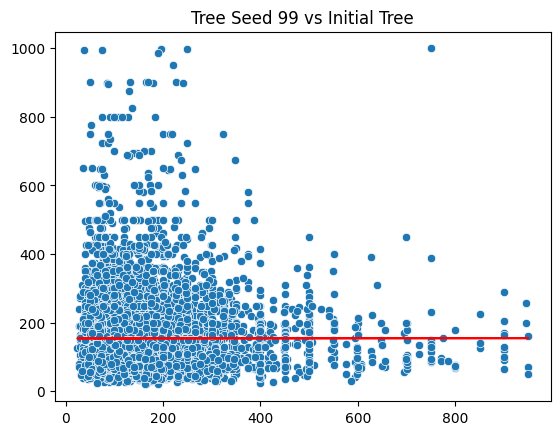

Seed 2025:
Intercept: 153.54082389672863
Coefficient: [0.00359326]
R^2: 1.3657267967204234e-05


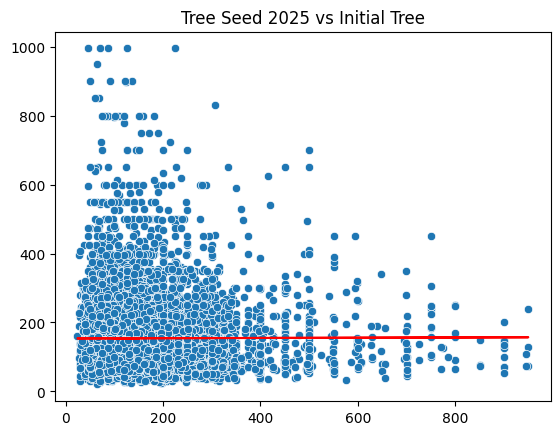

In [15]:
for key, preds in predictions.items():
    seed, model_type = key
    if model_type == "tree":
        sns.scatterplot(x=initial_tree, y=preds)
        model = LinearRegression().fit(initial_tree.reshape(-1, 1), preds)
        print(f"Seed {seed}:")
        print(f"Intercept: {model.intercept_}")
        print(f"Coefficient: {model.coef_}")
        print(f"R^2: {model.score(initial_tree.reshape(-1, 1), preds)}")
        plt.title(f"Tree Seed {seed} vs Initial Tree")
        plt.plot(initial_tree, model.predict(initial_tree.reshape(-1, 1)), color='red')
        plt.show()

### 5.
When comparing the coefficients and predictions across train/test splits for the linear models, we can see that the results are all quite similar; there is little variability between different seeds. At the same time, tree models can have slightly different structures while still maintaining similar predictions across train/test splits. Referring back to the `results_df` from question 3, we can see that a tree model with a seed of 0 has a slightly smaller depth than all the other tree models. Tree leaves also vary slightly across models. Yet, the standard deviation for both properties are quite low relative to their mean values, maintaining the idea that their structures are quite stable, as well.

In [16]:
coef_df

,0,7,42,99,2025
Review Scores Rating (bin),-3.320937e+00,-3.766166e+00,-3.318357e+00,-3.745852e+00,-3.675195e+00
Zipcode,1.944462e-04,1.218062e-04,1.053392e-04,1.136060e-04,1.971997e-04
Beds,3.458759e+01,3.427599e+01,3.449418e+01,3.367688e+01,3.394745e+01
Number of Records,2.199664e-10,-5.844021e-10,7.597434e-11,3.362827e-10,4.473077e-11
Number Of Reviews,-2.686723e-01,-2.663254e-01,-2.586182e-01,-2.807717e-01,-2.480641e-01
Review Scores Rating,4.412092e+00,4.882055e+00,4.403830e+00,4.825005e+00,4.797210e+00
Neighbourhood _Brooklyn,2.301307e+01,2.343709e+01,2.481660e+01,2.584479e+01,2.316471e+01
Neighbourhood _Manhattan,7.628480e+01,7.588259e+01,7.698999e+01,7.807937e+01,7.553140e+01
Neighbourhood _Queens,8.420152e+00,8.480594e+00,1.178569e+01,9.073958e+00,9.994097e+00
Neighbourhood _Staten Island,-3.735206e+00,-4.348016e+00,1.137580e+00,1.496467e-02,-9.929848e+00


In [18]:
results_df

,seed,r2_tree,rmse_tree,r2_lin,rmse_lin,tree_depth,tree_n_leaves
0,0,0.190795,99.686602,0.413905,84.838221,32,12760
1,7,0.257715,95.837186,0.423010,84.495322,34,12791
2,42,0.261799,95.808029,0.413469,85.400421,34,12851
3,99,0.270335,91.936744,0.442972,80.327791,34,12771
4,2025,0.273398,94.581942,0.420747,84.448924,34,12773


### 6.
This statement is true for both models. Linear models are inherently stable, as their "structure" is determined by the weights used for each feature. When the training set is tweaked (like having different seeds), the distribution of data remains largely the same, and so the calculated coefficients change only in the slightest. With similar appearances, the predictions between different linear models remain quite similar as well.

Even though trees are structurally unstable (as we observed with different tree depths and leaf counts), their predictions on new data are typically quite similar. When comparing the initial tree model with the other models trained using different seeds, there is a recurring pattern of predicted values, even if the splits and layout of the tree differ. This is because the different tree structures can partition the feature space in functionally similar ways, leading to nearly identical predicted outcomes. Thus, despite large changes in appearance, the underlying predictive behavior across decision tree models often remains stable.